# **Space X  Falcon 9 First Stage Landing Prediction**


##  Machine Learning Prediction


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


### Import Libraries and Define Auxiliary Functions


In [31]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

This function is to plot the confusion matrix.


In [32]:
def plot_confusion_matrix(y, y_predict):
    "This Function plots the Confusion Matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True,
                ax=ax); # annot=True to annotate cells
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(["did not land", "land"]);
    ax.yaxis.set_ticklabels(["did not land", "land"])
    plt.show()

### Load the dataframe


In [33]:
import requests
import io

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"

# Make Request
resp1 = requests.get(URL1)
resp1.raise_for_status()

# Read the CSV Content into DataFrame
data = pd.read_csv(io.StringIO(resp1.text))

# Display the Initial few rows
data.head()



,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [34]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'

# Make Request
resp2 = requests.get(URL2)
resp2.raise_for_status()

# Read the CSV into DataFrame
X = pd.read_csv(io.StringIO(resp2.text))

# Display the first 100 rows
X.head(100)


,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


We need to create a NumPy array from the `Class` column in our dataframe `data`.

In [35]:
y = data["Class"].to_numpy()

In [36]:
# Create a Numpy array from the column "class"
# Split the Data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

Now, we will Standardize the data in `X` then reassign it to the variable `X` using the transform provided below

In [37]:
transform = preprocessing.StandardScaler()

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


In [38]:
# Split the Data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [39]:
y_test.shape

(18,)

we can see we only have 18 test samples.


Now, we weill Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10 to  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [40]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [41]:
log_reg = LogisticRegression()

# Create a GridCV Object
log_reg_cv = GridSearchCV(
    estimator = log_reg,
    param_grid = parameters,
    cv=10,
    scoring="accuracy"
    )

# Fit the GridSearchCV Object to the training data
log_reg_cv.fit(X_train, y_train)

# Display the Best Parameters
print("tuned hyperparameters: (best parameters)\n ", log_reg_cv.best_params_)
print("Accuracy :", log_reg_cv.best_score_)


tuned hyperparameters: (best parameters)
  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy : 0.8035714285714285


now we calculate the accuracy on the test data

In [42]:
test_accuracy = log_reg_cv.score(X_test, y_test)

# Display the Accuracy
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.9444444444444444


Let's look at the Confusion Matrix


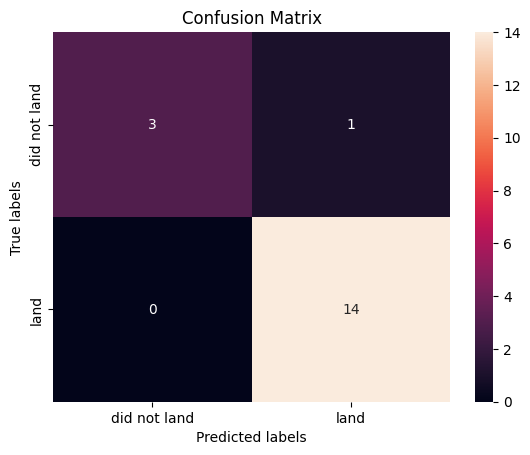

In [43]:
# Make Prediction
yhat = log_reg_cv.predict(X_test)

# Display the Confusion Matrix
plot_confusion_matrix(y_test, yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the problem is false positives.

Overview:

True Postive - 14 (True label is landed, Predicted label is also landed)

False Postive - 3 (True label is not landed, Predicted label is landed)

### Let's Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [44]:
parameters = {
    'kernel': ['linear', 'rbf'],          
    'C': [0.1, 1, 10],                    
    'gamma': [0.01, 0.1, 1]               
}

svm = SVC()

In [45]:
svm_cv = GridSearchCV(
    estimator=SVC(),
    param_grid=parameters,
    cv=10,
    scoring="accuracy",
    verbose=3,
    n_jobs=-1
)

# Fit the SVM Model
svm_cv.fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=3)

In [58]:
# Display the Best Parameters
print("Tuned hyperparameters (best parameters):\n", svm_cv.best_params_)
print("Accuracy:", svm_cv.best_score_)

Tuned hyperparameters (best parameters):
 {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Accuracy: 0.7910714285714285


Let's Calculate the accuracy on the test data using the method `score`:

In [47]:
test_accuracy = svm_cv.score(X_test, y_test)

# Display the Test Accuracy
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.9444444444444444


Now, we can plot the `Confusion Matrix`

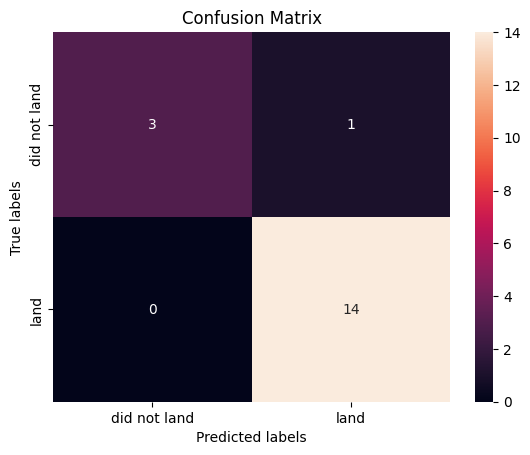

In [48]:
# Make Predicions
yhat = svm_cv.predict(X_test)

# Display the Confusion Matrix
plot_confusion_matrix(y_test, yhat)

Let's Create a decision tree classifier object then create a `GridSearchCV` object `tree_cv` with cv = 10. Fit the object to find the best parameters from the dictionary `parameters`.

In [49]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [50]:
tree_cv = GridSearchCV(
    estimator=tree,
    param_grid=parameters,
    cv=10,
    scoring="accuracy"
)

# Fit the Model
tree_cv.fit(X_train, y_train)

# Display the best parameters
print("tuned hyperparameters :(best parameters)\n", tree_cv.best_params_)
print("Accuracy:", tree_cv.best_score_)

tuned hyperparameters :(best parameters)
 {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Accuracy: 0.8732142857142857


Let's Calculate the accuracy on the test data using the method `score`:

In [51]:
test_accuracy = tree_cv.score(X_test, y_test)

# Display the Test Accuracy
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8333333333333334


we can plot the `Confusion Matrix`

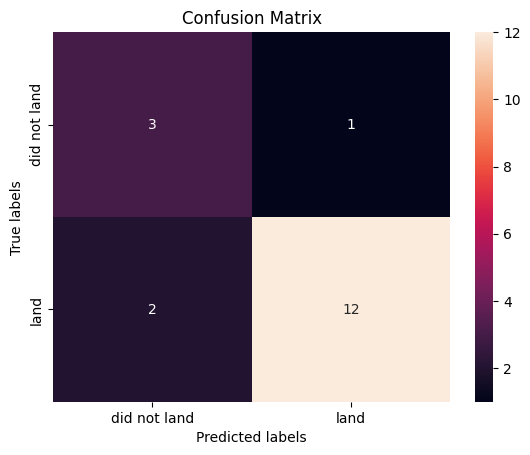

In [52]:
# Make Prediction
yhat = tree_cv.predict(X_test)

# Display the Confusion Matrix
plot_confusion_matrix(y_test, yhat)

Let's Create a `k nearest neighbors` object then create a `GridSearchCV` object `knn_cv` with cv = 10. Fit the object to find the best parameters from the dictionary parameters.

In [53]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [54]:
knn_cv = GridSearchCV(
    estimator=KNN,
    param_grid=parameters,
    cv=10,
    scoring="accuracy"
)

# Fit the model using training data
knn_cv.fit(X_train, y_train)

# Best parameters found
print("tuned hyperparameters :(best parameters)", knn_cv.best_params_)
print("Accuracy:", knn_cv.best_score_)

tuned hyperparameters :(best parameters) {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
Accuracy: 0.6928571428571428



Let's Calculate the accuracy of knn_cv on the test data using the method `score`:

In [55]:
test_accuracy = knn_cv.score(X_test, y_test)

# Display the Test Accuracy
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.5


Now, We can plot the `confusion matrix`


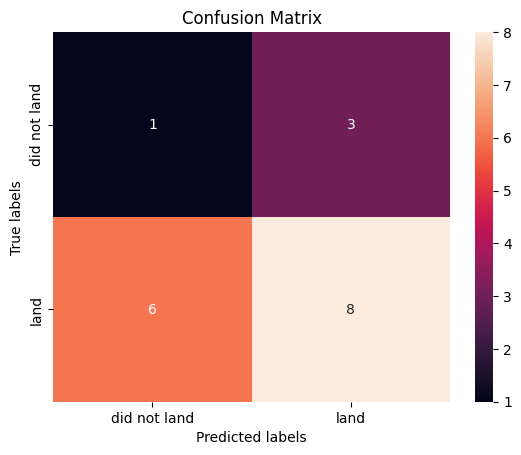

In [56]:
# Make Predictions
yhat = knn_cv.predict(X_test)

# Display the Confusion Matrix
plot_confusion_matrix(y_test, yhat)

#### Now, we will Find the method performs best:


In [57]:
Report = pd.DataFrame({'Method' : ['Test Data Accuracy']})

knn_accuracy=knn_cv.score(X_test, y_test)
Decision_tree_accuracy=tree_cv.score(X_test, y_test)
SVM_accuracy=svm_cv.score(X_test, y_test)
Logistic_Regression=log_reg_cv.score(X_test, y_test)

Report['Logistic_Reg'] = [Logistic_Regression]
Report['SVM'] = [SVM_accuracy]
Report['Decision Tree'] = [Decision_tree_accuracy]
Report['KNN'] = [knn_accuracy]




Report.transpose()

,0
Method,Test Data Accuracy
Logistic_Reg,0.944444
SVM,0.944444
Decision Tree,0.833333
KNN,0.5


#### Interpretation :
- Both **Logistic Regression** and **SVM** achieved the **highest accuracy (94.44%)**, indicating strong generalization on test data.  
- **Decision Tree** performed moderately well but may have **overfitted** the training data.  
- **KNN** showed poor performance (**50% accuracy**), likely due to feature scaling issues or unsuitable `k` value.

---

####  Conclusion :
- The **best performing models** are **Logistic Regression** and **SVM**.  
- **SVM** can be chosen for high accuracy and robustness.  
- **Logistic Regression** is simpler, interpretable, and performs equally well — ideal if model explainability is important.


----